In [1]:
import torch
from torch import nn, save, load
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from time import time
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
train = datasets.MNIST(root = '.', train = True, transform = ToTensor(), download = True)
train_dataset = DataLoader(train, batch_size = 32, shuffle = True)

100%|██████████| 9912422/9912422 [00:00<00:00, 89881380.75it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 27221504.23it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24839690.24it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5226482.52it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
class DigitsClassifier(nn.Module):

    def __init__(self) -> None:
        super().__init__()

        self.model = nn.Sequential()

        # in_channels, out_channels, kernel_size,
        self.model.add_module("conv2d_1", nn.Conv2d(in_channels = 1, out_channels = 16, 
                                               kernel_size = 3, padding = 1))             # padding = (kernel_size - 1) // 2

        self.model.add_module("ReLU_1", nn.ReLU())
        self.model.add_module("MaxPool2D_1", nn.MaxPool2d(kernel_size = 2, padding=1))    # padding = (kernel_size - 1) // 2
        self.model.add_module('BatchNorm_1', nn.BatchNorm2d(num_features = 16))           # num features = out_channels of the conv2d layer
        self.model.add_module("Dropout2D_1", nn.Dropout2d(p = 0.25))


        self.model.add_module("conv2d_2", nn.Conv2d(in_channels = 16, out_channels = 32,  # in_channels = out_channels of the previous layer
                                               kernel_size = 3, padding = 1))             # padding = (kernel_size - 1) // 2

        self.model.add_module("ReLU_2", nn.ReLU())
        self.model.add_module("MaxPool2D_2", nn.MaxPool2d(kernel_size = 2, padding=1))    # padding = (kernel_size - 1) // 2
        self.model.add_module('BatchNorm_2', nn.BatchNorm2d(num_features = 32))           # num features = out_channels of the conv2d layer
        self.model.add_module("Dropout2D_2", nn.Dropout2d(p = 0.25))


        self.model.add_module("conv2d_3", nn.Conv2d(in_channels = 32, out_channels = 64,  # in_channels = out_channels of the previous layer
                                               kernel_size = 3, padding = 1))             # padding = (kernel_size - 1) // 2

        self.model.add_module("ReLU_3", nn.ReLU())
        self.model.add_module("MaxPool2D_3", nn.MaxPool2d(kernel_size = 2, padding=1))    # padding = (kernel_size - 1) // 2
        self.model.add_module('BatchNorm_3', nn.BatchNorm2d(num_features = 64))           # num features = out_channels of the conv2d layer
        self.model.add_module("Dropout2D_3", nn.Dropout2d(p = 0.25))

        """self.model.add_module("Flatten",nn.Flatten())
        self.model.add_module("Dense",nn.Linear(in_features = 64*(28-6)*(28-6)           # 64 2d channels/feature maps of size 22 x 22
                                             , out_features = 10, bias=True))"""            # 10 output classes
        self.model.add_module("Flatten",nn.Flatten())
        self.model.add_module("Dense", nn.Linear(in_features = 64 * 5 * 5,  # x64 2d 5x5 channels/feature maps
                                                 out_features=10))          # 10 output classes
        self.model.add_module("softmax", nn.LogSoftmax(dim=1) )


    def forward(self, x):
        return self.model(x)



In [4]:
# Specify the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
digit_classifier = DigitsClassifier().to(device)  # CPU by default
print(f"Model running on {device}")

Model running on cpu


In [5]:
from torchsummary import summary
summary(digit_classifier, input_size = (1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 15, 15]               0
       BatchNorm2d-4           [-1, 16, 15, 15]              32
         Dropout2d-5           [-1, 16, 15, 15]               0
            Conv2d-6           [-1, 32, 15, 15]           4,640
              ReLU-7           [-1, 32, 15, 15]               0
         MaxPool2d-8             [-1, 32, 8, 8]               0
       BatchNorm2d-9             [-1, 32, 8, 8]              64
        Dropout2d-10             [-1, 32, 8, 8]               0
           Conv2d-11             [-1, 64, 8, 8]          18,496
             ReLU-12             [-1, 64, 8, 8]               0
        MaxPool2d-13             [-1, 64, 5, 5]               0
      BatchNorm2d-14             [-1, 6

In [6]:
# hyperparameters
EPOCHS = 25
LR = 1e-3

# optimizing model parameters with a leaerning rate of 1e-3
opt = Adam(params = digit_classifier.parameters(), lr = LR)

# specifying the loss function as cross entropy
loss_fn = nn.CrossEntropyLoss()

In [7]:
# Training flow

losses = []
accuracies = []
losses_per_batch = []


beg = time()
for epoch in range(EPOCHS):
    for batch in train_dataset:
        
        # unpacking input features and labels
        x, y = batch
        # Move the input data and labels to the specified device
        x, y = x.to(device), y.to(device)
        # yhat == predicted label
        yhat = digit_classifier(x)
        loss = loss_fn(yhat, y)

        # backpropagation
        opt.zero_grad()     # zero out the gradient
        loss.backward()     # Computes the gradient of current loss
        opt.step()          # optimize i.e update model paramerters to reduce loss

        #losses_per_batch.append(loss)

    print(f"Epoch {epoch} : train_loss : {loss:.4f}")
    #print(yhat.shape)
    losses.append(loss.item())

duration = int(time() - beg)
print(f"training on {device} lasted for {duration // 60 } min {duration % 60} sec")


Epoch 0 : train_loss : 0.3084
Epoch 1 : train_loss : 0.0768
Epoch 2 : train_loss : 0.0189
Epoch 3 : train_loss : 0.0241
Epoch 4 : train_loss : 0.0188
Epoch 5 : train_loss : 0.1134
Epoch 6 : train_loss : 0.0054
Epoch 7 : train_loss : 0.0078
Epoch 8 : train_loss : 0.0134
Epoch 9 : train_loss : 0.0103
Epoch 10 : train_loss : 0.0013
Epoch 11 : train_loss : 0.0099
Epoch 12 : train_loss : 0.0006
Epoch 13 : train_loss : 0.0220
Epoch 14 : train_loss : 0.2354
Epoch 15 : train_loss : 0.0643
Epoch 16 : train_loss : 0.0025
Epoch 17 : train_loss : 0.0175
Epoch 18 : train_loss : 0.0020
Epoch 19 : train_loss : 0.0010
Epoch 20 : train_loss : 0.0064
Epoch 21 : train_loss : 0.0014
Epoch 22 : train_loss : 0.0376
Epoch 23 : train_loss : 0.1635
Epoch 24 : train_loss : 0.0303
training on cpu lasted for 16 min 4 sec


In [8]:
# saving the model
with open('model_state.pt', 'wb') as f: 
    save(digit_classifier.state_dict(), f) 


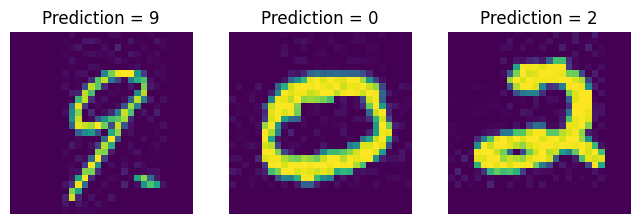

In [9]:

# run predictions :

# load model params
with open('model_state.pt', 'rb') as f: 
    digit_classifier.load_state_dict(load(f)) 

fig = plt.figure(figsize=(8, 5))
images = ['img_3.jpg', 'img_2.jpg', 'img_1.jpg']

for i , image in enumerate(images):

    fig.add_subplot(1, len(images), i+1)

    img = Image.open(image) 
    plt.imshow(img)
    plt.axis('off') 

    # preprocessing input   
    img_tensor = ToTensor()(img).unsqueeze(0).to(device)
    # running inference
    label = torch.argmax(digit_classifier(img_tensor)).item()
    plt.title(f"Prediction = {str(label)}")


    #print(label)

[0.30840766429901123, 0.07676935195922852, 0.018864046782255173, 0.02408142387866974, 0.018810711801052094, 0.1133894994854927, 0.00535312294960022, 0.0077715180814266205, 0.013366572558879852, 0.010342005640268326, 0.0012854983797296882, 0.00988083891570568, 0.000643374805804342, 0.021996933966875076, 0.23537445068359375, 0.06430727988481522, 0.0025265468284487724, 0.017534499987959862, 0.002014968078583479, 0.001032412750646472, 0.006389974150806665, 0.0014054448110982776, 0.03763658180832863, 0.1635209619998932, 0.030256349593400955]
25


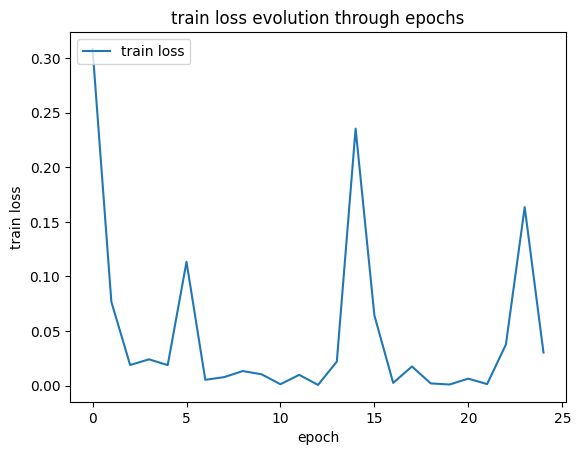

In [10]:
print(losses)
print(len(losses))
#print(range(5))
# Plot the loss curve
plt.plot([i for i in range(EPOCHS)], losses)

# Add labels and title
plt.xlabel('epoch')
plt.ylabel('train loss')
plt.title('train loss evolution through epochs')
plt.legend(['train loss'], loc='upper left')
# Display the plot
plt.show()
